In [69]:
import os
import sys
from pathlib import Path

# Add source directory to system path
source_dir = str(Path(os.getcwd()).parent / 'src')
sys.path.append(source_dir)

Label: 3


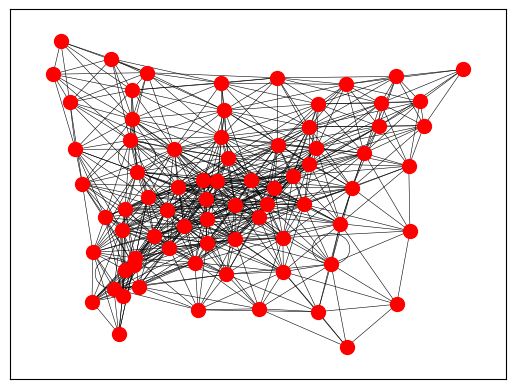

In [70]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.utils import to_networkx
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np

root = str(Path(os.getcwd()).parent / 'data' / 'mnist-superpixels')
dataset = MNISTSuperpixels(root=root)
sample = dataset[int(np.random.sample()*len(dataset))]
print("Label: {}".format(sample.y[0].cpu().numpy()))
G = to_networkx(sample, to_undirected=True)
nx.draw_networkx(G, with_labels=False, node_size=100, node_color="red", width=0.4)

In [71]:
from models import GNN
model = GNN(dataset.num_features, 512, dataset.num_classes, numLayers=2, dropout=0.2)
print("Number of Model Parameters: {}".format(sum(p.numel() for p in model.parameters())))
print(model)

Number of Model Parameters: 795146
GNN(
  (convs): ModuleList(
    (0): GraphSage(1, 512)
    (1): GraphSage(512, 512)
  )
  (postMP): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (logSoftmax): LogSoftmax(dim=1)
)


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from tqdm import tqdm


# Training Parameters
num_epochs = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# dataset = dataset[: int(len(dataset) * 0.5)]   # comment out if using full dataset
train_split, valid_split, test_split = 0.8, 0.1, 0.1
train_size = int(len(dataset) * train_split)
valid_size = int(len(dataset) * valid_split)
test_size = int(len(dataset) * test_split)

# Hyperparameters
learning_rate = 0.0001

# Data Loader
batch_size = 64
train_loader = DataLoader(dataset[: train_size], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset[train_size: train_size + valid_size], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset[train_size + valid_size:], batch_size=batch_size, shuffle=True)

# Loss Function and Optimizer
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
losses = []
train_accs = []
test_accs = []
best_acc = 0
best_model = None

for epoch in range(num_epochs):
  total_loss = 0
  total_acc = 0.0
  model.train()
  for data in tqdm(train_loader):
    data.to(device)
    optimizer.zero_grad()
    pred = model(data)
    # pred = pred[data.train_mask]
    label = data.y
    # label = label[data.train_mask]
    loss = loss_func(pred, label)
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * data.num_graphs
    total_acc += torch.sum(torch.where(torch.argmax(pred, dim=1) == label, 1, 0))
  total_loss /= len(train_loader.dataset)
  total_acc /= len(train_loader.dataset)
  losses.append(total_loss)

  model.eval()
  valid_acc = 0.0
  for data in valid_loader:
    with torch.no_grad():
      data.to(device)
      pred = model(data)
      label = data.y
      valid_acc += torch.sum(torch.where(torch.argmax(pred, dim=1) == label, 1, 0))
  valid_acc /= len(valid_loader.dataset)

  print("Epoch {} | Training Loss: {:.5f} | Train Acc.: {:.4f} | Valid Acc.: {:.4f}".format(epoch, losses[-1], total_acc, valid_acc))

100%|██████████| 750/750 [00:12<00:00, 59.71it/s]


Epoch 0 | Training Loss: 2.05024 | Train Acc.: 0.2149 | Valid Acc.: 0.2780


100%|██████████| 750/750 [00:11<00:00, 65.54it/s]


Epoch 1 | Training Loss: 1.81963 | Train Acc.: 0.3284 | Valid Acc.: 0.3605


100%|██████████| 750/750 [00:11<00:00, 65.57it/s]


Epoch 2 | Training Loss: 1.71392 | Train Acc.: 0.3761 | Valid Acc.: 0.3887


100%|██████████| 750/750 [00:11<00:00, 65.68it/s]


Epoch 3 | Training Loss: 1.59962 | Train Acc.: 0.4217 | Valid Acc.: 0.4443


100%|██████████| 750/750 [00:11<00:00, 65.13it/s]


Epoch 4 | Training Loss: 1.54862 | Train Acc.: 0.4412 | Valid Acc.: 0.4537


100%|██████████| 750/750 [00:11<00:00, 64.88it/s]


Epoch 5 | Training Loss: 1.50922 | Train Acc.: 0.4539 | Valid Acc.: 0.4820


100%|██████████| 750/750 [00:11<00:00, 64.30it/s]


Epoch 6 | Training Loss: 1.46708 | Train Acc.: 0.4701 | Valid Acc.: 0.4990


100%|██████████| 750/750 [00:11<00:00, 65.67it/s]


Epoch 7 | Training Loss: 1.43179 | Train Acc.: 0.4881 | Valid Acc.: 0.5003


100%|██████████| 750/750 [00:11<00:00, 65.66it/s]


Epoch 8 | Training Loss: 1.40080 | Train Acc.: 0.4966 | Valid Acc.: 0.5208


100%|██████████| 750/750 [00:11<00:00, 65.48it/s]


Epoch 9 | Training Loss: 1.37584 | Train Acc.: 0.5082 | Valid Acc.: 0.5370


100%|██████████| 750/750 [00:11<00:00, 65.57it/s]


Epoch 10 | Training Loss: 1.35920 | Train Acc.: 0.5162 | Valid Acc.: 0.5427


100%|██████████| 750/750 [00:11<00:00, 65.45it/s]


Epoch 11 | Training Loss: 1.33329 | Train Acc.: 0.5265 | Valid Acc.: 0.5423


100%|██████████| 750/750 [00:11<00:00, 66.12it/s]


Epoch 12 | Training Loss: 1.31322 | Train Acc.: 0.5341 | Valid Acc.: 0.5020


100%|██████████| 750/750 [00:11<00:00, 66.08it/s]


Epoch 13 | Training Loss: 1.29900 | Train Acc.: 0.5401 | Valid Acc.: 0.5498


100%|██████████| 750/750 [00:11<00:00, 65.96it/s]


Epoch 14 | Training Loss: 1.28844 | Train Acc.: 0.5419 | Valid Acc.: 0.5517


100%|██████████| 750/750 [00:11<00:00, 65.26it/s]


Epoch 15 | Training Loss: 1.27079 | Train Acc.: 0.5489 | Valid Acc.: 0.5702


100%|██████████| 750/750 [00:11<00:00, 65.64it/s]


Epoch 16 | Training Loss: 1.26021 | Train Acc.: 0.5531 | Valid Acc.: 0.5497


100%|██████████| 750/750 [00:11<00:00, 65.49it/s]


Epoch 17 | Training Loss: 1.25012 | Train Acc.: 0.5593 | Valid Acc.: 0.5593


100%|██████████| 750/750 [00:11<00:00, 66.14it/s]


Epoch 18 | Training Loss: 1.24084 | Train Acc.: 0.5616 | Valid Acc.: 0.5692


100%|██████████| 750/750 [00:11<00:00, 63.45it/s]


Epoch 19 | Training Loss: 1.23606 | Train Acc.: 0.5625 | Valid Acc.: 0.5728


100%|██████████| 750/750 [00:11<00:00, 65.14it/s]


Epoch 20 | Training Loss: 1.21705 | Train Acc.: 0.5721 | Valid Acc.: 0.5915


100%|██████████| 750/750 [00:11<00:00, 64.96it/s]


Epoch 21 | Training Loss: 1.20894 | Train Acc.: 0.5761 | Valid Acc.: 0.5800


100%|██████████| 750/750 [00:11<00:00, 65.13it/s]


Epoch 22 | Training Loss: 1.19811 | Train Acc.: 0.5804 | Valid Acc.: 0.5975


100%|██████████| 750/750 [00:11<00:00, 65.22it/s]


Epoch 23 | Training Loss: 1.18453 | Train Acc.: 0.5852 | Valid Acc.: 0.6027


100%|██████████| 750/750 [00:11<00:00, 65.15it/s]


Epoch 24 | Training Loss: 1.17667 | Train Acc.: 0.5893 | Valid Acc.: 0.5853


100%|██████████| 750/750 [00:11<00:00, 63.49it/s]


Epoch 25 | Training Loss: 1.16566 | Train Acc.: 0.5926 | Valid Acc.: 0.5920


100%|██████████| 750/750 [00:11<00:00, 63.16it/s]


Epoch 26 | Training Loss: 1.16525 | Train Acc.: 0.5936 | Valid Acc.: 0.5832


100%|██████████| 750/750 [00:11<00:00, 65.48it/s]


Epoch 27 | Training Loss: 1.15161 | Train Acc.: 0.5989 | Valid Acc.: 0.6175


100%|██████████| 750/750 [00:11<00:00, 65.39it/s]


Epoch 28 | Training Loss: 1.14778 | Train Acc.: 0.6002 | Valid Acc.: 0.6047


100%|██████████| 750/750 [00:11<00:00, 65.36it/s]


Epoch 29 | Training Loss: 1.13483 | Train Acc.: 0.6057 | Valid Acc.: 0.6268


100%|██████████| 750/750 [00:11<00:00, 65.53it/s]


Epoch 30 | Training Loss: 1.13335 | Train Acc.: 0.6074 | Valid Acc.: 0.6110


100%|██████████| 750/750 [00:11<00:00, 65.50it/s]


Epoch 31 | Training Loss: 1.12366 | Train Acc.: 0.6100 | Valid Acc.: 0.6060


100%|██████████| 750/750 [00:11<00:00, 65.60it/s]


Epoch 32 | Training Loss: 1.11612 | Train Acc.: 0.6104 | Valid Acc.: 0.6165


100%|██████████| 750/750 [00:11<00:00, 65.61it/s]


Epoch 33 | Training Loss: 1.11245 | Train Acc.: 0.6128 | Valid Acc.: 0.6337


100%|██████████| 750/750 [00:11<00:00, 65.64it/s]


Epoch 34 | Training Loss: 1.10511 | Train Acc.: 0.6159 | Valid Acc.: 0.6300


100%|██████████| 750/750 [00:11<00:00, 65.56it/s]


Epoch 35 | Training Loss: 1.10213 | Train Acc.: 0.6182 | Valid Acc.: 0.6257


100%|██████████| 750/750 [00:11<00:00, 65.20it/s]


Epoch 36 | Training Loss: 1.09028 | Train Acc.: 0.6210 | Valid Acc.: 0.6357


100%|██████████| 750/750 [00:11<00:00, 65.47it/s]


Epoch 37 | Training Loss: 1.08597 | Train Acc.: 0.6227 | Valid Acc.: 0.6367


100%|██████████| 750/750 [00:11<00:00, 65.24it/s]


Epoch 38 | Training Loss: 1.08046 | Train Acc.: 0.6264 | Valid Acc.: 0.6480


100%|██████████| 750/750 [00:11<00:00, 65.41it/s]


Epoch 39 | Training Loss: 1.07659 | Train Acc.: 0.6251 | Valid Acc.: 0.6025


100%|██████████| 750/750 [00:11<00:00, 65.76it/s]


Epoch 40 | Training Loss: 1.07740 | Train Acc.: 0.6281 | Valid Acc.: 0.6300


100%|██████████| 750/750 [00:11<00:00, 65.69it/s]


Epoch 41 | Training Loss: 1.06424 | Train Acc.: 0.6319 | Valid Acc.: 0.6422


100%|██████████| 750/750 [00:11<00:00, 65.43it/s]


Epoch 42 | Training Loss: 1.06350 | Train Acc.: 0.6329 | Valid Acc.: 0.6472


100%|██████████| 750/750 [00:11<00:00, 65.63it/s]


Epoch 43 | Training Loss: 1.06514 | Train Acc.: 0.6311 | Valid Acc.: 0.6188


100%|██████████| 750/750 [00:11<00:00, 64.91it/s]


Epoch 44 | Training Loss: 1.05501 | Train Acc.: 0.6332 | Valid Acc.: 0.6532


100%|██████████| 750/750 [00:11<00:00, 65.45it/s]


Epoch 45 | Training Loss: 1.05024 | Train Acc.: 0.6385 | Valid Acc.: 0.6525


100%|██████████| 750/750 [00:11<00:00, 64.38it/s]


Epoch 46 | Training Loss: 1.04389 | Train Acc.: 0.6405 | Valid Acc.: 0.6440


100%|██████████| 750/750 [00:11<00:00, 65.88it/s]


Epoch 47 | Training Loss: 1.03907 | Train Acc.: 0.6408 | Valid Acc.: 0.6525


100%|██████████| 750/750 [00:11<00:00, 65.09it/s]


Epoch 48 | Training Loss: 1.03909 | Train Acc.: 0.6429 | Valid Acc.: 0.6605


100%|██████████| 750/750 [00:11<00:00, 65.63it/s]


Epoch 49 | Training Loss: 1.03145 | Train Acc.: 0.6435 | Valid Acc.: 0.6492


100%|██████████| 750/750 [00:11<00:00, 65.65it/s]


Epoch 50 | Training Loss: 1.02984 | Train Acc.: 0.6463 | Valid Acc.: 0.6688


100%|██████████| 750/750 [00:11<00:00, 65.81it/s]


Epoch 51 | Training Loss: 1.02732 | Train Acc.: 0.6488 | Valid Acc.: 0.6418


100%|██████████| 750/750 [00:11<00:00, 65.45it/s]


Epoch 52 | Training Loss: 1.02981 | Train Acc.: 0.6461 | Valid Acc.: 0.6673


100%|██████████| 750/750 [00:11<00:00, 65.56it/s]


Epoch 53 | Training Loss: 1.02075 | Train Acc.: 0.6484 | Valid Acc.: 0.6492


100%|██████████| 750/750 [00:11<00:00, 65.55it/s]


Epoch 54 | Training Loss: 1.01944 | Train Acc.: 0.6491 | Valid Acc.: 0.6550


100%|██████████| 750/750 [00:11<00:00, 65.59it/s]


Epoch 55 | Training Loss: 1.01585 | Train Acc.: 0.6506 | Valid Acc.: 0.6547


 11%|█         | 84/750 [00:01<00:10, 60.73it/s]


KeyboardInterrupt: 